In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import math

from ucimlrepo import fetch_ucirepo

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.preprocessing import LabelBinarizer
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

from sklearn.datasets import load_iris, load_wine, fetch_olivetti_faces, load_digits, make_blobs, make_moons

# Lecture 7: Linear Separation Algorithms

## References

- [Logistic regression - Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=In%20statistics%20%2C%20A%20logistic,or%20a%20%20122%20continuous)
- [Plotting the decision boundary of a logistic regression model](https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/#:~:text=Alternatively%2C%20one%20can%20think%20of,txt%2C%20which%20maybe)
- [Convergence of Gradient Descent](https://www.cs.ubc.ca/~schmidtm/Courses/540-W18/L4.pdf#:~:text=2%20Xv,regularization%2C%20making%20solution%20unique)
- [Gradient Descent Converges Linearly for Logistic Regression](https://openreview.net/forum?id=CKATCkQFcdJ#:~:text=Gradient%20Descent%20Converges%20Linearly%20for,is%20reliant%20upon%20the)
- [Support Vector Machine - Wikipedia](https://en.wikipedia.org/wiki/Support_vector_machine#:~:text=,true%20for%20image%20segmentation%20systems)
- [Training complexity of Linear SVM - Stack Overflow](https://stackoverflow.com/questions/16585465/training-complexity-of-linear-svm#:~:text=Training%20complexity%20of%20nonlinear%20SVM,following%20papers%20are%20good%20references)
- [SVC — scikit-learn 1.6.1 documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#:~:text=C)


## 1. Logistic Regression

Logistic regression is a **classification model** used for predicting binary outcomes (two classes) by modeling the probability of one class (usually labeled “1”) as a function of input features. Unlike linear regression which outputs an unbounded continuous value, logistic regression outputs a probability in the range $[0,1]$ by using the **logistic (sigmoid) function** as a link. In statistical terms, it is a model that expresses the *log-odds* of an event (class $1$ vs class $0$) as a linear combination of the features. The logistic function then converts these log-odds into a probability between 0 and 1. This ensures the prediction can be interpreted as a valid probability of belonging to the positive class.

**Motivation:** For a binary classification task (e.g. spam vs not-spam, pass vs fail), we want a model that not only classifies but also provides a confidence (probability). A linear model $f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b$ by itself is not bounded – it can produce any real number, making it unsuitable as a probability estimator. Simply thresholding a linear function (as in a perceptron) yields hard classifications but no calibrated probabilities, and predictions can lie outside $[0,1]$. Logistic regression addresses this by applying the sigmoid function to the linear output, squeezing it into $[0,1]$. The model’s prediction $\hat{y} = P(y=1|\mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x} + b)$ can be thresholded at 0.5 for classification: if $\hat{y}\ge 0.5$ predict class 1, otherwise class 0. This way, logistic regression behaves like a linear classifier but with the additional advantage of probabilistic interpretation.

**Comparison with Linear Classification (Geometric Interpretation):** Geometrically, logistic regression is very similar to other *linear classifiers* in that it uses a linear decision boundary in the feature space to separate the two classes. The weight vector $\mathbf{w}$ and bias $b$ define a hyperplane $\{\mathbf{x} : \mathbf{w}^T\mathbf{x} + b = 0\}$ that separates the space into two half-spaces. All points for which $\mathbf{w}^T\mathbf{x} + b > 0$ will be classified (with probability $>0.5$) as class 1, and those with $\mathbf{w}^T\mathbf{x} + b < 0$ as class 0. This is the same kind of linear separation used by perceptrons or linear Support Vector Machines. The key difference is that logistic regression produces *soft* outputs (probabilities) and is typically trained by maximizing likelihood, whereas a perceptron produces a hard decision (0/1) and is usually trained by error-correcting rules. In essence, logistic regression can be seen as a “smoothed” version of a hard threshold classifier – instead of a step function jump at the boundary, it transitions smoothly from 0 to 1 across the boundary region. This smoothness has advantages for optimization (the function is differentiable everywhere) and for interpreting the output as confidence. 

## 1.1. Mathematical Formulation

**Logistic Function Derivation:** The core of logistic regression is the *logistic function*, also known as the sigmoid function. It arises from the requirement that we model the **log-odds** (logit) of the probability linearly. Let $p(\mathbf{x}) = P(y=1|\mathbf{x})$ denote the probability of class 1 given features $\mathbf{x}$. We assume the log-odds is linear: 

$$ \text{logit}(p) \;=\; \ln\frac{p(\mathbf{x})}{1 - p(\mathbf{x})} \;=\; \mathbf{w}^T \mathbf{x} + b, $$ 

where $\mathbf{w}=(w_1,\ldots,w_d)$ are the feature weights and $b$ is the intercept. Solving for $p(\mathbf{x})$, we exponentiate both sides: $\frac{p}{1-p} = \exp(\mathbf{w}^T\mathbf{x}+b)$. This gives 
$$ p(\mathbf{x}) \;=\; \frac{1}{\,1 + \exp[-(\mathbf{w}^T\mathbf{x} + b)]\,}.$$ 
We define the **logistic (sigmoid) function** $\sigma(z) = \frac{1}{1+e^{-z}}$. Using this, we can succinctly write the model as:
$$ p(\mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x} + b). $$ 
This $\sigma(z)$ is an S-shaped curve mapping any real number $z$ to the range $(0,1)$. In particular, as $z \to +\infty$, $\sigma(z)\to 1$ and as $z\to -\infty$, $\sigma(z)\to 0$. At $z=0$, $\sigma(0)=0.5$, meaning when the linear combination is zero, the predicted probability is 50%. 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/8/88/Logistic-curve.svg">

**Figure:** The logistic sigmoid function $\sigma(z)=\frac{1}{1+e^{-z}}$. It maps any real-valued input $z$ into the range $(0,1)$, producing an S-shaped curve. The function is symmetric about $z=0$ (where $\sigma=0.5$) and has horizontal asymptotes at 0 and 1.*
</center>

**Properties of the Logistic Function:** The sigmoid $\sigma(z)$ is a **monotonic increasing** function of $z$ (larger linear scores yield higher predicted probability). Its first derivative is $\sigma'(z) = \sigma(z)\big(1-\sigma(z)\big)$. This derivative is important in optimization because it is simple and never zero for finite $z$ (since $\sigma(z)$ is in (0,1) for all finite $z$). Specifically, $\sigma'(z)$ achieves a maximum of $0.25$ at $z=0$ and decays toward 0 as $z$ goes to $\pm\infty$. Intuitively, this means the model is most *sensitive* to changes in $z$ (and hence in $\mathbf{w}$) when $p=0.5$, whereas if $p$ is very close to 0 or 1, changes in the linear score have little effect on the probability (the curve flattens out). The logistic function is infinitely differentiable and convex in $z$ for $z>0$ (concave for $z<0$), but importantly the *log-likelihood* built from it will be concave in the parameters, as we will see.

**Probabilistic Interpretation:** In logistic regression, we interpret $p(\mathbf{x})=\sigma(\mathbf{w}^T \mathbf{x} + b)$ as the conditional probability $P(y=1 \mid \mathbf{x})$ under the model parameters $(\mathbf{w},b)$. Thus, $P(y=0|\mathbf{x}) = 1 - p(\mathbf{x}) = \sigma(-(\mathbf{w}^T\mathbf{x}+b))$. We can think of logistic regression as **fitting a Bernoulli probability model** for $y$ given $x$. In other words, for each training example $\mathbf{x}^{(i)}$, the observed label $y^{(i)}\in\{0,1\}$ is assumed to be a Bernoulli random variable with success probability $p^{(i)} = \sigma(\mathbf{w}^T \mathbf{x}^{(i)} + b)$. This probabilistic view means logistic regression is a form of a **probabilistic classifier**: it doesn’t directly output a class label, but a probability from which a label can be derived. It also places logistic regression in the framework of **generalized linear models (GLMs)** with the logit as the link function, and in the exponential family (the logistic function is the natural parameterization of the Bernoulli distribution). The advantage of this interpretation is that we can use principled methods like Maximum Likelihood Estimation for training (see next section), and we can quantify uncertainty in predictions.

**Decision Boundary Equation and Geometry:** Although logistic regression outputs probabilities, to actually classify an observation we typically choose a cutoff (usually 0.5). The **decision boundary** is defined as the set of points in feature space where $P(y=1|\mathbf{x}) = P(y=0|\mathbf{x}) = 0.5$. Setting $p(\mathbf{x}) = 0.5$ in the logistic model yields $\sigma(\mathbf{w}^T\mathbf{x} + b) = 0.5$. Since $\sigma(0)=0.5$ and $\sigma$ is strictly increasing, this occurs if and only if $\mathbf{w}^T \mathbf{x} + b = 0$. Thus, the equation of the decision boundary is 
$$ \mathbf{w}^T \mathbf{x} + b = 0, $$ 
which is a **linear equation** defining a hyperplane in $\mathbb{R}^d$. All points on one side of this hyperplane will have $\mathbf{w}^T\mathbf{x}+b>0$ and hence $p(\mathbf{x})>0.5$ (predicted class 1), and points on the other side have $\mathbf{w}^T\mathbf{x}+b<0$ and $p(\mathbf{x})<0.5$ (predicted class 0). For a simple two-feature example ($x_1, x_2$), this boundary is a straight line. For instance, we can solve for $x_2$ in terms of $x_1$: $w_1 x_1 + w_2 x_2 + b = 0$ gives $x_2 = -\frac{w_1}{w_2}x_1 - \frac{b}{w_2}$, a line with slope $-w_1/w_2$ and intercept $-b/w_2$. The normal vector to this hyperplane is $\mathbf{w}$ itself: $\mathbf{w}$ points in the direction where the model’s output increases (toward class 1), and the magnitude $|\mathbf{w}|$ relates to how confidently or steeply the probabilities change around the boundary. Geometrically, logistic regression finds the orientation of this separating hyperplane that best fits the training data in a probabilistic sense.

## 1.2. Maximum Likelihood Estimation (MLE)
**Likelihood of the Data:** Given a training dataset $\{(\mathbf{x}^{(i)}, y^{(i)})\}_{i=1}^N$ with $y^{(i)} \in \{0,1\}$, we can write down the likelihood of seeing these outcomes under the logistic regression model. Assuming the data points are independent, the *likelihood function* (viewed as a function of the parameters $\mathbf{w},b$) is:

$$ L(\mathbf{w},b) = \prod_{i=1}^N P(y^{(i)} \mid \mathbf{x}^{(i)};\mathbf{w},b). $$

Using our model, $P(y^{(i)}=1|\mathbf{x}^{(i)}) = \sigma(\mathbf{w}^T\mathbf{x}^{(i)}+b)$ and $P(y^{(i)}=0|\mathbf{x}^{(i)}) = 1 - \sigma(\mathbf{w}^T\mathbf{x}^{(i)}+b)$. We can combine these into one expression: 
$$ P(y^{(i)}|\mathbf{x}^{(i)}) = [\sigma(\mathbf{w}^T\mathbf{x}^{(i)}+b)]^{y^{(i)}} \, [1-\sigma(\mathbf{w}^T\mathbf{x}^{(i)}+b)]^{\,1 - y^{(i)}}. $$ 
This works because if $y^{(i)}=1$, it picks out the first factor $\sigma(\cdot)$, and if $y^{(i)}=0$, it picks out the second factor. Therefore, the likelihood is:
$$ L(\mathbf{w},b) \;=\; \prod_{i=1}^N \Big(\sigma(\mathbf{w}^T\mathbf{x}^{(i)}+b)\Big)^{y^{(i)}} \Big(1-\sigma(\mathbf{w}^T\mathbf{x}^{(i)}+b)\Big)^{\,1-y^{(i)}}.$$

**Log-Likelihood Function:** It is usually easier to work with the **log-likelihood**, $\ell(\mathbf{w},b) = \ln L(\mathbf{w},b)$, which turns the product into a sum. Taking logarithms:

$$
\ell(\mathbf{w},b) = \sum_{i=1}^N \Big[\,y^{(i)} \ln \sigma(z^{(i)}) + (1 - y^{(i)}) \ln\!\big(1 - \sigma(z^{(i)})\big)\Big],
$$ 

where for brevity $z^{(i)} = \mathbf{w}^T\mathbf{x}^{(i)} + b$. This expansion is a sum of two terms for each data point: if $y^{(i)}=1$ we get $\ln \sigma(z^{(i)})$, and if $y^{(i)}=0$ we get $\ln(1-\sigma(z^{(i)}))$. We can verify that this matches the form of a Bernoulli log-likelihood: 

$$ \ell(\mathbf{w},b) = \sum_{i=1}^N \Big( y^{(i)} \ln p^{(i)} + (1 - y^{(i)}) \ln(1 - p^{(i)}) \Big), $$ 

where $p^{(i)} = \sigma(\mathbf{w}^T\mathbf{x}^{(i)}+b)$. This is sometimes called the **logistic log-likelihood**. It measures how well a given parameter setting $\mathbf{w},b$ explains the observed labels: higher $\ell$ means the predicted probabilities $p^{(i)}$ are closer to 1 for the instances that are actually $y=1$, and closer to 0 for instances that are $y=0$. 

Our goal in training is to find the parameters that *maximize* this log-likelihood — this is the principle of **Maximum Likelihood Estimation (MLE)**. Intuitively, MLE chooses the parameters that make the observed data most probable. In the context of logistic regression, maximizing the likelihood is equivalent to finding the parameters that best discriminate between the two classes in probabilistic terms.

**Why MLE for Parameter Estimation:** MLE is a natural choice because under mild conditions it produces statistically consistent and efficient estimates of the true parameters as the sample size grows. By formulating the training objective as likelihood maximization, we are directly aligning the model’s probability estimates with the empirical data. An alternative could be minimizing some error rate or squared error, but for classification those can be less tractable or non-differentiable. The log-likelihood of logistic regression is nicely behaved (concave) and yields a unique optimum under reasonable conditions, making it convenient for optimization. Furthermore, maximizing the likelihood is equivalent to minimizing the *cross-entropy* or *log loss* between the predicted probabilities and the actual labels, a common measure of classification error.

To see the connection to **cross-entropy loss**, note that *negative* log-likelihood is:

$$ -\ell(\mathbf{w},b) = \sum_{i=1}^N \Big( -y^{(i)} \ln p^{(i)} - (1 - y^{(i)}) \ln(1 - p^{(i)}) \Big) = \sum_{i=1}^N \Big( y^{(i)} \, \big(-\ln p^{(i)}\big) + (1-y^{(i)})\,\big(-\ln(1-p^{(i)})\big) \Big). $$

This is exactly the binary cross-entropy (logistic loss) for the predictions $p^{(i)}$ w.rt. the true labels. Minimizing this is the same as maximizing $\ell$. We prefer the log-likelihood view here because of its direct probabilistic interpretation.

**Convexity and Existence of Optimum:** A crucial feature of the logistic log-likelihood is that it is a **concave function** in the parameters $(\mathbf{w},b)$ (for fixed data). Equivalently, the *negative* log-likelihood $J(\mathbf{w},b) = -\ell(\mathbf{w},b)$ is a **convex function**. This can be shown by examining the second derivative (Hessian). Without going into full matrix calculus detail here, one can show that the Hessian matrix of $J$ is $X^T D X$ where $X$ is the design matrix of inputs and $D$ is a diagonal matrix with entries $p^{(i)}(1-p^{(i)})$ for each example’s current predicted probability. Each term $p^{(i)}(1-p^{(i)})$ is non-negative, making $X^T D X$ positive semidefinite. This implies the function $J(\mathbf{w},b)$ is globally convex. In practical terms, this means **any local minimum of the cost is a global minimum**. As long as the data are not perfectly separable, the log-likelihood is strictly concave and the optimum is unique. If the data *are* perfectly separable, the likelihood increases without bound as $\|\mathbf{w}\| \to \infty$ in a direction that perfectly separates the classes – in other words, the MLE does not exist (the model will try to make $p^{(i)} \to 1$ for all positive examples and $0$ for all negatives by blowing up the weights). In such cases, one usually applies **regularization** (see Section 6) to obtain a finite solution.

Having transformed our problem into the task of maximizing a concave log-likelihood (or equivalently minimizing a convex loss), we can now apply standard optimization algorithms to find the best parameters. Notably, unlike linear regression, **no closed-form solution exists** for logistic regression parameters that maximize the likelihood. This is due to the sigmoid in the likelihood which makes the equations nonlinear. Therefore, we resort to **iterative optimization methods**, discussed next.

## 1.3. Optimization and Gradient Descent
To maximize the log-likelihood $\ell(\mathbf{w},b)$, we can take its gradient with respect to the parameters and set it to zero (the first-order optimality condition). This yields the so-called *normal equations* for logistic regression. Let’s derive the **gradient of the log-likelihood**. For each parameter $w_j$ (component of $\mathbf{w}$) and the intercept $b$, we differentiate $\ell$:

- For the weight $w_j$ (assuming feature $x_j$ for each example): 
  $$
  \frac{\partial \ell}{\partial w_j} = \sum_{i=1}^N \Big[ y^{(i)} \frac{\partial}{\partial w_j} \ln \sigma(z^{(i)}) + (1-y^{(i)}) \frac{\partial}{\partial w_j} \ln(1-\sigma(z^{(i)})) \Big],
  $$ 
  where $z^{(i)} = \mathbf{w}^T\mathbf{x}^{(i)} + b$. Using the chain rule: $\frac{\partial}{\partial w_j}\ln \sigma(z^{(i)}) = \frac{1}{\sigma(z^{(i)})} \sigma'(z^{(i)}) \frac{\partial z^{(i)}}{\partial w_j}$. We know $\sigma'(z^{(i)}) = \sigma(z^{(i)})(1-\sigma(z^{(i)})) = p^{(i)}(1-p^{(i)})$. Also $\frac{\partial z^{(i)}}{\partial w_j} = x_j^{(i)}$. So $\frac{\partial}{\partial w_j}\ln \sigma(z^{(i)}) = \frac{p^{(i)}(1-p^{(i)})x_j^{(i)}}{p^{(i)}} = (1-p^{(i)})x_j^{(i)}$. Similarly, $\frac{\partial}{\partial w_j}\ln(1-\sigma(z^{(i)})) = \frac{-p^{(i)}(1-p^{(i)})x_j^{(i)}}{\,1-p^{(i)}\,} = -p^{(i)} x_j^{(i)}$. Plugging these in:
  $$
  \frac{\partial \ell}{\partial w_j} = \sum_{i=1}^N \Big[ y^{(i)} (1-p^{(i)}) x_j^{(i)} - (1-y^{(i)}) p^{(i)} x_j^{(i)} \Big] = \sum_{i=1}^N \big[\,y^{(i)} - p^{(i)}\big] x_j^{(i)}. 
  $$ 
  The last step comes from observing that the term inside the sum simplifies: $y^{(i)}(1-p^{(i)}) - (1-y^{(i)})p^{(i)} = y^{(i)} - y^{(i)}p^{(i)} - p^{(i)} + y^{(i)}p^{(i)} = y^{(i)} - p^{(i)}$. 

- For the intercept $b$: $\frac{\partial \ell}{\partial b} = \sum_{i=1}^N [y^{(i)} - p^{(i)}] \frac{\partial z^{(i)}}{\partial b} = \sum_{i=1}^N [y^{(i)} - p^{(i)}]$ since $\partial z^{(i)}/\partial b = 1$.

These are the **gradient equations**. In vector form, let $\mathbf{y}=(y^{(1)},\dots,y^{(N)})^T$ and $\mathbf{p}=(p^{(1)},\dots,p^{(N)})^T$, and let $X$ be the $N\times d$ matrix of features (not including the column of ones for intercept). Then the gradient with respect to $\mathbf{w}$ can be written as: 

$$ \nabla_{\mathbf{w}} \ell = X^T(\mathbf{y} - \mathbf{p}), $$ 

and $\frac{\partial \ell}{\partial b} = \sum_{i}(y^{(i)}-p^{(i)})$. Setting these derivatives to zero yields the system of *estimating equations*:
$$ X^T(\mathbf{y} - \mathbf{p}) = \mathbf{0}, \qquad \sum_{i=1}^N (y^{(i)}-p^{(i)}) = 0. $$
However, these equations are nonlinear in $\mathbf{w}$ (note $\mathbf{p}$ depends on $\mathbf{w}$), and cannot be solved in closed-form for $\mathbf{w}$. This confirms why we must use iterative methods: we need to *search* for the $\mathbf{w},b$ that satisfy these equations (i.e. maximize the log-likelihood). 

**Gradient Ascent / Descent Algorithm:** The most basic approach to find the MLE is **Gradient Ascent** on the log-likelihood (or equivalently, Gradient Descent on the negative log-likelihood). The idea is to start with an initial guess for the parameters $(\mathbf{w},b)$ and then repeatedly update the parameters in the direction of increasing likelihood. In gradient ascent form, the update rule is:
$$ \mathbf{w} \leftarrow \mathbf{w} + \alpha \,\nabla_{\mathbf{w}}\ell(\mathbf{w},b), \qquad 
   b \leftarrow b + \alpha \,\frac{\partial \ell}{\partial b}, $$ 
where $\alpha$ is a small positive learning rate. Substituting our gradient formulas, this becomes:
$$ w_j \leftarrow w_j + \alpha \sum_{i=1}^N (y^{(i)} - p^{(i)})\,x_j^{(i)}, \qquad 
   b \leftarrow b + \alpha \sum_{i=1}^N (y^{(i)} - p^{(i)}).$$ 
Equivalently, one often writes it as gradient **descent** on the loss $J=-\ell$:
$$ w_j \leftarrow w_j - \alpha \sum_{i=1}^N (p^{(i)} - y^{(i)})\,x_j^{(i)},$$ 
which is the same update since $p^{(i)}-y^{(i)} = -(y^{(i)}-p^{(i)})$. This rule has a nice interpretation: it adjusts each weight $w_j$ by an amount proportional to the correlation between feature $x_j$ and the prediction error $(y - p)$. If for some feature $x_j$ the model consistently underestimates $y$ (so $y^{(i)}-p^{(i)}$ is positive when $x_j$ is high), then $w_j$ will be increased, making $\mathbf{w}^T\mathbf{x}$ bigger and thus raising predictions on those instances. Conversely, if $x_j$ contributes to overestimation (predicting too high when $y=0$), then $w_j$ will be decreased. The intercept update increases $b$ if there are more positives than the current model predicts, or decreases it if there are more negatives, effectively adjusting the overall bias of the decision boundary.

One can either use the full dataset gradient (called **batch gradient descent**) as above, or use **stochastic gradient descent (SGD)** which updates the parameters incrementally for each training example (or mini-batches of examples). SGD is often more efficient for large datasets and can escape shallow local extrema, but in our case the loss is convex so there is a single global optimum – SGD will oscillate around it but can find it as well given decaying learning rate.

**Convergence Properties:** Because the logistic regression loss $J(\mathbf{w})$ is convex and differentiable, gradient descent is guaranteed to converge to the global minimum *as long as* the learning rate $\alpha$ is chosen appropriately (for example, small enough or decayed over time). In practice, one might need to choose $\alpha$ carefully: too large can cause overshooting or divergence, while too small yields very slow progress. There are well-known strategies for setting or adapting the learning rate (learning rate schedules, line search, etc.). 

The convergence of gradient descent can also be accelerated using second-order methods. A popular choice for logistic regression is **Newton’s method**, which uses the Hessian to take more direct steps to the optimum. Newton’s method for logistic regression is known as **Iteratively Reweighted Least Squares (IRLS)** in the statistics literature, and it converges in fewer iterations (often just a handful) by solving a local quadratic approximation of the loss at each step. However, each Newton step is more computationally expensive (inverting a Hessian matrix or solving linear systems). For moderate feature dimensions, IRLS/Newton’s method is very fast. For very high-dimensional data, one may use Quasi-Newton methods like BFGS or stochastic second-order methods.

**Computational Efficiency:** Each iteration of batch gradient descent for logistic regression requires computing the predictions $p^{(i)}$ for all $N$ examples and then computing the gradients, which is $O(N \times d)$ operations (where $d$ is number of features). This is quite feasible for moderate $N$ and $d$. If $N$ is extremely large, SGD can reduce the cost per iteration to $O(d)$ by updating with one (or a few) sample at a time. The trade-off is that SGD typically requires more iterations to converge (because of noise in the updates), but each iteration is cheaper. In practice, logistic regression is often trained with very efficient libraries that use vectorized operations and convergence criteria (stopping when change in likelihood or parameters is below a threshold). Thanks to convexity, we don’t have to worry about getting stuck in local minima, only about reaching the global minimum efficiently. Modern solvers can handle logistic regression with millions of instances and features, especially with the help of SGD or distributed training.

## 1.4. Decision Boundary and Separability
**Linear Decision Boundary:** As derived earlier, logistic regression inherently yields a linear decision boundary in the original feature space. We can formally state: *Logistic regression always finds a (generalized) linear separator between the two classes.* The boundary is given by $\{\mathbf{x}: \mathbf{w}^T\mathbf{x} + b = 0\}$. This is a result of the model’s structure – the predicted probability is $\sigma(\mathbf{w}^T \mathbf{x} + b)$, and the dividing surface where $\sigma(\cdot)=0.5$ is exactly where its argument $\mathbf{w}^T\mathbf{x}+b$ is zero. No matter what training algorithm or data is given, the output of logistic regression (without modifications like polynomial features or kernels) will be of the form $\mathbf{w}^T\mathbf{x}+b$, meaning the separation it can represent is a single hyperplane. We can provide a short proof/derivation of this: The decision rule for classifying an instance $\mathbf{x}$ is usually $\hat{y} = \mathbf{1}\{P(y=1|\mathbf{x}) \ge 0.5\}$ (where $\mathbf{1}\{\cdot\}$ is the indicator function). Equivalently, $\hat{y} = \mathbf{1}\{\sigma(\mathbf{w}^T\mathbf{x}+b) \ge 0.5\}$. Apply the logit (which is monotonic increasing) to both sides of $\sigma(\mathbf{w}^T\mathbf{x}+b) \ge 0.5$: this is the same as $\mathbf{w}^T\mathbf{x} + b \ge 0$ (since $\text{logit}(0.5)=0$). Thus $\hat{y}=1$ iff $\mathbf{w}^T\mathbf{x} + b \ge 0$, and $\hat{y}=0$ otherwise. This is precisely a half-space classification defined by the linear equation $\mathbf{w}^T\mathbf{x} + b = 0$. The vector $\mathbf{w}$ is perpendicular to this boundary, and the magnitude $|\,\mathbf{w}^T\mathbf{x} + b\,|$ (the signed distance times $||\mathbf{w}||$) indicates how confidently $\mathbf{x}$ is on one side or the other. In summary, logistic regression **will always produce a linear decision surface** (unless we *engineer features* to make it nonlinear, see below).

**Separability and Failure Cases:** A limitation of using a single linear separator is that if the true relationship between $\mathbf{x}$ and $y$ is non-linear, logistic regression may not fit the data well. For example, consider an XOR pattern in 2D: points of class 1 are at diagonally opposite corners of a square and class 0 at the other two corners. No single straight line can separate class 1 and 0 in this case (the data is **not linearly separable** in the original feature space). Logistic regression applied directly to such data will still output some linear boundary – essentially a line that best splits the difference – but it will make errors for points that are not linearly separable. In this sense, logistic regression *fails to capture* the structure of non-linearly separable data. It doesn’t fail to produce a result (it will still converge to a set of parameters), but the resulting classifier will have high bias (systematic errors) because the model is too simple to describe the true decision boundary.

![Plotting the decision boundary of a logistic regression model](https://scipython.com/static/media/uploads/blog/logistic_regression/decision-boundary.png)
*Figure: Example of a logistic regression decision boundary for a two-class dataset. The model finds a linear separating line (dashed) that best partitions the blue class (below the line) and the orange class (above the line). If the true class boundary is approximately linear, logistic regression will perform well. However, it cannot form more complex boundaries (curves, multiple disconnected regions) without transforming the input features.* 

In linearly **separable** cases (where a perfect linear boundary *does* exist), logistic regression can fit the data very well. In fact, as mentioned earlier, if the classes are perfectly separable, the maximum likelihood solution tends to push $||\mathbf{w}|| \to \infty$, making the probability for each point of class 1 approach 1 and class 0 approach 0. In practice, when data is separable, logistic regression still often works but you may observe the weights growing very large during training, and the model might become numerically unstable or overfit. Regularization (Section 6) is commonly used to handle this by limiting the growth of weights. 

In summary, logistic regression finds a linear boundary, so it is inherently limited to problems that are linearly separable in the feature space (or nearly so). If the data is not linearly separable, logistic regression’s decision boundary will be the *best linear approximation* — which could still be effective if the classes are approximately linearly separable or if the decision boundary is roughly linear. If the data truly requires a non-linear boundary, one must either **add more features** (for instance, polynomial features to allow a curved boundary) or use a different model (e.g. decision trees, kernel SVM, neural networks) that can capture non-linear relations.

## 1.5. Extensions of Logistic Regression

**Multiclass Logistic Regression (Softmax Regression):** Logistic regression as discussed is for binary classification. It can be extended to handle **$K$-class classification** (where $K>2$ classes) in two main ways: **one-vs-rest** or **multinomial logistic regression**. The one-vs-rest (OvR) approach trains $K$ separate binary logistic regressions, each one distinguishing one class from the other $K-1$ (treating those as "negative"). This can work but treats the classes independently and may not be optimal as it doesn’t capture the mutual exclusion between classes. The more principled extension is **multinomial logistic regression**, also known as **softmax regression** or the **MaxEnt (maximum entropy) classifier**. In this model, we have a weight vector (and bias) for each class. Let’s denote by $\mathbf{w}^{(j)}$ the weight vector for class $j$ (and possibly an intercept $b^{(j)}$). We choose an arbitrary reference class (sometimes class 0) and set its score to zero as a baseline (this is to avoid redundancy, since probabilities must sum to 1). The model then says the **log-odds** of class $j$ versus the reference class 0 is linear: 

$$ \ln \frac{P(y=j \mid \mathbf{x})}{P(y=0 \mid \mathbf{x})} = \mathbf{w}^{(j)T} \mathbf{x} + b^{(j)}, \quad \text{for } j=1,2,\dots, K-1.$$ 

From these, we can derive the probabilities. Exponentiating the equations: $\frac{P(y=j|\mathbf{x})}{P(y=0|\mathbf{x})} = \exp(\mathbf{w}^{(j)T}\mathbf{x}+b^{(j)})$. Also all probabilities sum to 1. Solving for $P(y=j|\mathbf{x})$ yields the **softmax formula**:

$$ P(y=j \mid \mathbf{x}) = \frac{\exp(\mathbf{w}^{(j)T}\mathbf{x} + b^{(j)})}{\displaystyle \sum_{u=0}^{K-1} \exp(\mathbf{w}^{(u)T}\mathbf{x} + b^{(u)})}, \qquad j=0,1,\dots,K-1.$$ 

Often we fold the bias into the weight vector by appending a constant feature 1, for simplicity of notation. In that case $\mathbf{w}^{(j)} \cdot \mathbf{x}$ implicitly includes the bias term. The above formula shows that the probability for each class is given by the exponential of that class’s linear score, normalized by the sum of exponentials of all class scores. This is the **softmax function** (a multi-class generalization of the logistic sigmoid). Note that if $K=2$, this reduces to a form equivalent to the logistic function. For $K=2$, say classes 0 and 1, the softmax gives $P(y=1) = \frac{e^{\mathbf{w}^{(1)T}\mathbf{x}}}{e^{\mathbf{w}^{(1)T}\mathbf{x}} + e^{\mathbf{w}^{(0)T}\mathbf{x}}}$. If we set $\mathbf{w}^{(0)}=\mathbf{0}$, then $P(y=1) = \frac{1}{1+e^{-\mathbf{w}^{(1)T}\mathbf{x}}}$ which is the logistic form. Thus logistic regression is a special case of softmax regression.

The parameters of a softmax regression model can be learned by MLE as well. The likelihood in the multi-class case is a product of multinomial probabilities for each example, and the log-likelihood can be derived similarly (it ends up being $ \ell = \sum_{i} \sum_{j=0}^{K-1} \mathbf{1}\{y^{(i)}=j\} \ln P(y=j|\mathbf{x}^{(i)})$). This log-likelihood is **convex** in the parameters (for the same reason as binary case, essentially because it’s a negative log of a softmax which is an exponential-family distribution). So we can again use gradient-based methods. The gradient for softmax has a similar form: $\frac{\partial \ell}{\partial \mathbf{w}^{(j)}} = \sum_{i} \big( \mathbf{1}\{y^{(i)}=j\} - P(y=j|\mathbf{x}^{(i)}) \big) \mathbf{x}^{(i)}$. Setting this to zero gives a set of non-linear equations that are solved by iterative methods (e.g. gradient ascent or Newton’s method extended for multi-class).

Geometrically, in a $K$-class logistic regression, the decision boundaries between any two classes are still linear. In a 2D feature space with 3 classes, for example, one gets a partition of the plane into three regions, each separated by lines (which may meet at junctions). One interesting note is that OvR (one-vs-rest) and softmax (multinomial) can produce different boundaries. Multinomial logistic considers all classes together and optimizes a single likelihood, often resulting in a more *efficient* use of data when classes are imbalanced or overlapping. OvR treats each class separation independently, which could lead to inconsistencies (e.g., regions where multiple classifiers would vote positive, or none do). However, OvR is simpler to implement and in practice can perform similarly if carefully calibrated. 

**Regularization Techniques (L1 and L2):** In many cases, especially when the number of features is large or the data is high-dimensional, one applies **regularization** to logistic regression. Regularization involves adding a penalty term to the loss function to discourage extreme or complex models, which helps prevent overfitting and can handle collinearity or separability issues. The two most common regularization schemes for logistic regression are **L2 regularization** (ridge) and **L1 regularization** (lasso).

- *L2 Regularization:* We add $\frac{\lambda}{2}\|\mathbf{w}\|^2$ (the sum of squared weights) to the loss function (and do not usually regularize the bias term). Equivalently, we add a Gaussian prior on weights in a Bayesian view. The new objective to **minimize** becomes 
  $$
  J_{\text{reg}}(\mathbf{w},b) = -\ell(\mathbf{w},b) + \frac{\lambda}{2}\sum_{j=1}^d w_j^2,
  $$ 
  where $\lambda > 0$ is the regularization hyperparameter controlling the strength of the penalty. L2 regularization tends to keep weights small (shrinks them towards zero but usually not exactly zero). It makes the loss function **strictly convex**, ensuring a unique minimum even in cases of perfect separation or correlated features. L2-regularized logistic regression is sometimes called “ridge logistic regression.” The effect of $\lambda$: a larger $\lambda$ heavily penalizes large weights (leading to a flatter decision boundary with more moderate probabilities), potentially underfitting but gaining simplicity, whereas $\lambda$ near 0 recovers the unregularized MLE (which could overfit if data is scarce relative to number of features).

- *L1 Regularization:* We add $\lambda \sum_{j=1}^d |w_j|$ to the loss (the sum of absolute values of weights). This is not differentiable at $w_j=0$, but it is convex and can be optimized with sub-gradient methods or coordinate descent. L1 regularization has the special property of inducing **sparsity** in the solutions: it tends to drive many weights *exactly* to zero, especially if $\lambda$ is large. Thus, L1-regularized logistic regression performs feature selection automatically by turning off irrelevant features. This can be very useful in high-dimensional settings (e.g., text classification with thousands of features) because it produces a simpler model that uses only a subset of features. In practice, one often uses libraries that implement L1 penalty using specialized optimizers (since the gradient is not defined at 0, standard gradient descent needs modification).

Both regularizations can also be combined (Elastic Net: a mix of L1 and L2) to get benefits of both. When using regularization, we are no longer doing pure MLE; we are doing **penalized maximum likelihood** or MAP estimation (Maximum a posteriori) if we view it from a Bayesian perspective (Gaussian prior for L2, Laplace prior for L1). The training process is otherwise similar, but the objective is modified. Regularization usually improves generalization performance, especially if the original model was at risk of overfitting. It also handles the issue of separability: for instance, with L2 regularization, even perfectly separable data will lead to a finite optimum weight vector (rather than it blowing up to infinity), because increasing weights further always incurs the quadratic penalty.

**Relationship to Support Vector Machines (SVMs):** Logistic regression and linear SVMs are both linear classifiers, but they come from different philosophical angles and have different loss functions. Logistic regression is probabilistic, optimizing the log-likelihood (logistic loss), whereas a linear SVM is a max-margin classifier, typically optimizing a hinge loss with a regularization term. Concretely, the SVM’s objective (primal form) can be written as minimizing 
$$ \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^N \max(0,\,1 - y^{(i)}(\mathbf{w}^T\mathbf{x}^{(i)}+b)\,),$$ 
where $y^{(i)} \in \{-1,+1\}$ for a binary SVM and $C$ is a parameter controlling trade-off between margin and slack (similar to $1/\lambda$ in regularization terms). The hinge loss $\max(0,1-yt)$ is 0 if the point is correctly classified with margin $\ge 1$, and grows linearly if not. The logistic loss, on the other hand, is $\ln(1+e^{-y t})$ which decays more gradually: it doesn’t plateau like the hinge loss, it will keep penalizing even well-classified points (though very mildly if $y t$ is large). This means logistic regression tends to be influenced by all points (each contributes some gradient), whereas an SVM’s solution is determined by only the *support vectors* (points on or within the margin). In practice, both methods often achieve similar classification accuracy. SVM may have an edge when classes are very unbalanced or when the focus is strictly on the boundary (and not on probabilistic outputs). Logistic regression has the advantage of providing calibrated probabilities and being easier to update or implement in online settings (hinge loss is not differentiable at the boundary, though subgradients are used). From a convex optimization perspective, both are convex problems; logistic regression’s loss is smooth (making gradient descent straightforward), while SVM’s hinge loss is piecewise-linear (often solved by Quadratic Programming or coordinate descent methods). Another connection: in the limit of small $\lambda$ (or large $C$ for SVM), both models will approach a similar *maximum-margin* solution. In fact, one can show that for very large $|\,\mathbf{w}\,|$, the logistic loss $\ln(1+e^{-y t})$ approaches $0$ if $y t$ is positive and large, so it starts to behave somewhat like a hinge (which is exactly 0 past the margin) but without a sharp cutoff. In summary, logistic regression and SVM often give comparable decision boundaries; logistic regression might be preferred if probability estimates are needed or the data is not too high-dimensional, whereas SVM might be preferred for certain structured kernels or when a sparse solution in terms of support vectors is desired.

**Relationship to Neural Networks:** Logistic regression can be viewed as the simplest form of a neural network. If we construct a neural network with no hidden layers – just an input layer directly connected to an output neuron with a sigmoid activation – that is exactly logistic regression. The input features $\mathbf{x}$ are fed directly into a single unit which computes $z=\mathbf{w}^T\mathbf{x}+b$ and then outputs $\sigma(z)$. In fact, logistic regression was one of the earliest forms of a “neural” model (the perceptron algorithm is similar but uses a threshold activation). It is commonly said that logistic regression is a 1-layer neural network (one layer of weights). This equivalence is noted in many machine learning texts: a logistic regression classifier is a *single-layer perceptron model with a sigmoid activation function*. Because the sigmoid function has a convenient derivative and is differentiable everywhere, it became a popular choice in early neural networks (allowing training via **backpropagation** in multi-layer networks). Training a logistic regression by gradient descent is essentially the same as training that single neuron in a neural network setting. 

The connection goes further: if one uses multiple logistic regression units in parallel, one for each class (with softmax normalization), that is equivalent to a neural network with a softmax output layer – essentially a generalization for multiclass classification used in modern neural networks. And if one stacks layers of such units (with non-linear activations), one moves beyond logistic regression into the realm of deep neural networks. In that sense, logistic regression is a fundamental building block: it represents how a linear combination of inputs can be turned into a probability. Indeed, many deep networks still use a final layer that is essentially logistic regression (sigmoid for binary or softmax for multi-class) to produce output probabilities.

**Notes:** 

- The derivations and properties discussed above are standard in many statistical machine learning texts and courses. Key formulations (log-odds linearity and sigmoid function) are outlined in sources like Wikipedia ([Logistic regression - Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=In%20statistics%20%2C%20A%20logistic,or%20a%20%20122%20continuous)) ([Logistic regression - Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=,22%20for%20a%20worked%20example)). 
- The log-likelihood expression and the fact that logistic regression yields a convex optimization problem can be found in many references ([Logistic regression - Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=Image%3A%20,y_%7Bk%7D%29%5Cln%281)) ([CPSC 540: Machine Learning - Convergence of Gradient Descent](https://www.cs.ubc.ca/~schmidtm/Courses/540-W18/L4.pdf#:~:text=2%20Xv,regularization%2C%20making%20solution%20unique)).
- For a deeper geometric interpretation of the decision boundary, one can refer to explanatory articles such as the SciPy blog visualization ([Plotting the decision boundary of a logistic regression model](https://scipython.com/blog/plotting-the-decision-boundary-of-a-logistic-regression-model/#:~:text=Alternatively%2C%20one%20can%20think%20of,txt%2C%20which%20maybe)).
- The relationship to neural networks is well documented as well ([Logistic regression - Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=This%20functional%20form%20is%20commonly,computed%20from%20the%20general%20form)) ([Logistic regression - Wikipedia](https://en.wikipedia.org/wiki/Logistic_regression#:~:text=layer%20neural%20network%20is%20identical,its%20derivative%20is%20easily%20calculated)). 

In [3]:
def experiment(X,y, splits=10):
    kcv = StratifiedKFold(n_splits=splits)
    model = LogisticRegression(max_iter=15000)
    scores = cross_val_score(model, X, y, cv=kcv, scoring='accuracy')
    stderr = st.sem(scores)
    mean = np.round(scores.mean(),4)
    interval = np.round(st.t.interval(0.05, df=splits-1, loc=mean, scale=stderr),4)
    return({'mean': mean, 'interval': interval})

In [4]:
heart_disease = fetch_ucirepo(id=45) 

heart_X = heart_disease.data.features 
heart_X.fillna(0,inplace=True)

binarizer = LabelBinarizer()

heart_y = heart_disease.data.targets 
heart_yy = binarizer.fit_transform(heart_y)

/tmp/ipykernel_202488/2194932026.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  heart_X.fillna(0,inplace=True)


In [5]:
experiment(heart_X,heart_yy[:,0])

{'mean': np.float64(0.8251), 'interval': array([0.8236, 0.8266])}

In [6]:
experiment(heart_X,heart_y)

/home/kaygun/.local/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/kaygun/.local/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kaygun/.local/lib/python3.13/site-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sam

{'mean': np.float64(0.6072), 'interval': array([0.6057, 0.6087])}

In [7]:
raw = load_digits()
digits_X = raw['data']
digits_y = raw['target']

binarizer = LabelBinarizer()
yy = binarizer.fit_transform(digits_y)

In [8]:
experiment(digits_X,yy[:,0])

{'mean': np.float64(0.9961), 'interval': array([0.996 , 0.9962])}

In [9]:
experiment(digits_X,digits_y)

{'mean': np.float64(0.9271), 'interval': array([0.9265, 0.9277])}

In [10]:
faces = fetch_olivetti_faces()
faces_X = faces['data']
faces_y = faces['target']

binarizer = LabelBinarizer()
yy = binarizer.fit_transform(faces_y)

In [11]:
experiment(faces_X,yy[:,0])

{'mean': np.float64(0.98), 'interval': array([0.9792, 0.9808])}

In [12]:
experiment(faces_X,faces_y)

{'mean': np.float64(0.98), 'interval': array([0.9795, 0.9805])}

In [13]:
wine = load_wine()
wine_X = wine['data']
wine_y = wine['target']
binarizer = LabelBinarizer()
yy = binarizer.fit_transform(wine_y)

In [14]:
experiment(wine_X,wine_y)

{'mean': np.float64(0.9667), 'interval': array([0.9661, 0.9673])}

## 2 SVM

**Definition and Motivation:**  

Support Vector Machines (SVMs) are a class of supervised learning models used for classification and regression tasks. They are **max-margin** classifiers, meaning they find a decision boundary that maximizes the margin (distance) between different class examples. In essence, an SVM attempts to find the “best” separating hyperplane between two classes by maximizing the gap (margin) between them. This approach is rooted in statistical learning theory – SVMs were developed by Vladimir Vapnik and colleagues at AT&T Bell Labs and are grounded in Vapnik–Chervonenkis (VC) theory. The motivation for maximizing the margin comes from the intuition (and theoretical result) that a larger margin often leads to better generalization on unseen data. By pushing the decision boundary as far as possible from all training points, the classifier aims to be less sensitive to small perturbations or noise in the data. Indeed, being max-margin models, SVMs tend to be resilient to overfitting even in high-dimensional spaces and can handle some misclassified or noisy examples gracefully .

Throughout this lecture, we will focus on the **binary classification** setup, where we have two classes (which we will label +1 and –1 for convenience). The goal is to learn a classifier from a labeled training set that can accurately predict the class label of new, unseen examples. Formally, assume we are given a training dataset of $n$ points of the form $\{(x_1, y_1), (x_2, y_2), \dots, (x_n, y_n)\}$, where each feature vector $x_i \in \mathbb{R}^p$ and each label $y_i \in \{+1,\,-1\}$ indicates membership in one of two classes. Our objective is to find a classifier $f(x)$ that will correctly predict the labels for these and future points. In an SVM, this classifier is a linear decision function **(a hyperplane)** that separates the two classes with the maximum possible margin.

## 2.1 Mathematical Foundation

**Hyperplanes and Separating Data:**  

In a $p$-dimensional feature space, the most general form of an affine **hyperplane** can be written as an equation $w^T x + b = 0$, where $w \in \mathbb{R}^p$ is the normal vector (weight vector) perpendicular to the hyperplane, and $b \in \mathbb{R}$ is the offset (bias) term. This hyperplane defines a decision boundary that splits the space into two half-spaces: $w^T x + b > 0$ on one side and $w^T x + b < 0$ on the other. An SVM will assign one class to points falling in the region $w^T x + b > 0$ and the other class to points where $w^T x + b < 0$. For example, we might decide that if $w^T x + b \ge 0$ the prediction is +1, and if $w^T x + b < 0$ the prediction is –1. The equation $w^T x + b = 0$ thus defines the **decision boundary** between the two classes. The sign of $w^T x + b$ gives the predicted class ($\operatorname{sgn}(w^T x + b)$ is the classifier’s output).

A dataset is said to be **linearly separable** if there exists at least one hyperplane that can perfectly classify all training points into the +1 and –1 sides without error. In geometric terms, the two classes can be separated by a straight line (in 2D), a plane (in 3D), or a hyperplane in higher dimensions. When the data is linearly separable, many possible separating hyperplanes might exist. SVM’s key idea is to choose the one that **maximizes the margin** of separation, which intuitively corresponds to the most “robust” separator.

**Decision Boundaries and Margin:**  
Consider any hyperplane $w^T x + b = 0$ that separates the +1 and –1 classes. We can characterize how well this hyperplane separates the data by looking at the **margin**, which is the distance from the hyperplane to the nearest data point. Specifically, for a given hyperplane $(w,b)$ and a data point $x_i$, the signed distance of $x_i$ from the hyperplane is 
$$\frac{y_i (w^T x_i + b)}{\|w\|}$$ 
This is positive if the point is on the correct side and negative if it violates the classification. The margin achieved by the hyperplane on the dataset is the smallest distance of any training point to the hyperplane. To maximize this margin, we can rescale $w$ and $b$ such that the points closest to the hyperplane satisfy $|w^T x_i + b| = 1$. Under this convention, the two **margin boundaries** (the hyperplanes that touch the closest points of each class) are defined by: 

- $w^T x + b = 1$ for the +1 class boundary, and 
- $w^T x + b = -1$ for the –1 class boundary. 

All +1 class points lie on or above $w^T x + b = 1$, and all –1 class points lie on or below $w^T x + b = -1$. The region between these two parallel hyperplanes is the **margin** (no training points fall inside this region for a fully separable dataset). Geometrically, the distance between the two margin boundaries is $\frac{2}{\|w\|}$. Therefore, maximizing the margin is equivalent to minimizing $\|w\|$. SVM optimizes this criterion with constraints ensuring all points are on the correct side of the margin.

<img width=400px, src="https://upload.wikimedia.org/wikipedia/commons/7/72/SVM_margin.png"> 
*Figure: Illustration of the maximum-margin hyperplane for a binary SVM in a 2D feature space. 

The red line is the separating hyperplane $w^T x + b = 0$. The blue and green points belong to two classes. The parallel dashed lines (in blue for $w^T x + b = 1$ and in green for $w^T x + b = -1$) show the boundaries of the margin. The vectors $w$ (normal to the hyperplane) and the margin distance $2/\|w\|$ are indicated. The points that lie exactly on the margin boundaries are the **support vectors** (circled in the figure); these points effectively determine the position of the optimal hyperplane.* 

The **support vectors** are the training examples that lie closest to the decision boundary – in fact, they satisfy $|w^T x_i + b| = 1$ at optimum. These points “support” or define the maximum-margin hyperplane; if they were removed or moved slightly, the optimal hyperplane would change. Points further away from the boundary (inside their respective class regions) do not directly influence the final solution. An important consequence of this is that the solution to an SVM is often sparse in terms of support vectors – only a subset of training points end up determining the decision boundary.

## 2.2 Optimization Problem

With the geometric picture in mind, we now formulate the SVM training as an optimization problem. We will first consider the **hard-margin SVM**, which assumes the data is linearly separable with no misclassification, and then extend it to the more general **soft-margin SVM** that allows some classification errors or overlap.

**Hard-Margin SVM (Separable Case):**  
For linearly separable data, the conditions for a hyperplane $(w, b)$ to correctly classify all points with a margin of at least 1 can be written as constraints: for every $i$ in $1,\dots,n$,

- If $y_i = +1$, then $w^T x_i + b \ge 1$ (the point lies on the +1 side of the margin boundary),  
- If $y_i = -1$, then $w^T x_i + b \le -1$ (the point lies on the –1 side of the margin boundary).  

These can be compactly written as a single inequality: 
$$ y_i (w^T x_i + b) \ge 1, \quad \forall\, i = 1,\dots,n. \tag{1} $$ 
This inequality ensures every point lies on the correct side of the margin and at least distance 1 from the decision boundary. Our goal is to find the hyperplane that satisfies these constraints while maximizing the margin $2/\|w\|$. Equivalently, we minimize $\tfrac{1}{2}\|w\|^2$ (using $\tfrac{1}{2}\|w\|^2$ is mathematically convenient and leads to the same solution as minimizing $\|w\|$). We can ignore the factor of 2 in the margin since scaling $w$ does not change the location of the hyperplane given the constraints in (1).

Putting it together, we have the **primal optimization problem** for the hard-margin SVM: 

$$
\begin{aligned}
\text{minimize}_{\,w,\,b} \quad & \frac{1}{2}\,\|w\|^2, \\
\text{subject to} \quad & y_i (w^T x_i + b) \ge 1, \quad i=1,\dots,n~.
\end{aligned}
$$

This is a convex optimization problem (specifically, a Quadratic Program, since the objective is quadratic and constraints are linear). Because it is convex, any local optimum is a global optimum. Solving this optimization yields the weight vector $w$ and bias $b$ that define the maximum-margin hyperplane. The resulting classifier is $f(x) = \operatorname{sgn}(w^T x + b)$, which predicts +1 if $w^T x + b \ge 0$ and –1 otherwise.

However, real-world data is often **not linearly separable** – there might be no hyperplane that can perfectly classify all points, or forcing a perfect separation might lead to overfitting in the presence of noise or outliers. To handle such cases, SVMs introduce a soft-margin through **slack variables**.

**Soft-Margin SVM (Non-separable Case):**  
To allow some points to violate the margin constraint (or even be misclassified), we introduce nonnegative slack variables $\{\zeta_i\}$ for each data point. The constraint (1) is relaxed to: 
$$ y_i (w^T x_i + b) \ge 1 - \zeta_i, \quad \zeta_i \ge 0, \quad \forall i. $$
Here $\zeta_i$ measures how much the $i$-th point violates the ideal margin condition. If $\zeta_i = 0$, the point lies outside or on its correct margin boundary. If $0 < \zeta_i < 1$, the point is inside the margin (closer to the boundary than it should be, but still on the correct side of the hyperplane). If $\zeta_i > 1$, the point is misclassified (it lies on the wrong side of the decision boundary). To penalize violations, the objective function is modified to include a penalty term proportional to the total slack. This leads to the **soft-margin optimization problem**:

$$
\begin{aligned}
\text{minimize}_{\,w,\,b,\,\{\zeta_i\}} \quad & \frac{1}{2}\,\|w\|^2 + C \sum_{i=1}^n \zeta_i, \\
\text{subject to} \quad & y_i (w^T x_i + b) \ge 1 - \zeta_i, \;\; \zeta_i \ge 0, \quad i=1,\dots,n~.
\end{aligned}
$$

The constant $C > 0$ is a regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors. Larger $C$ puts more weight on the slack penalty (thus heavily discouraging misclassification, at the cost of a smaller margin), while a smaller $C$ allows a wider margin at the expense of potentially more margin violations. In the limit $C \to \infty$, this approach approximates the hard-margin SVM if the data is separable. On the other hand, if $C$ is too small, the classifier might ignore important data points (allowing too many violations) and underfit. Choosing $C$ appropriately is important in practice.

**Lagrange Duality and KKT Conditions:**  
The constrained optimization problems above are typically solved using Lagrange duality. We introduce Lagrange multipliers $\alpha_i \ge 0$ for each constraint $y_i(w^T x_i + b) \ge 1 - \zeta_i$, and (for soft margin) additional multipliers $\mu_i \ge 0$ for the constraints $\zeta_i \ge 0$. Without going into all the algebraic details, the main idea is to form the Lagrangian:
$$ \mathcal{L}(w,b,\zeta,\alpha,\mu) = \frac{1}{2}\|w\|^2 + C\sum_{i}\zeta_i - \sum_{i}\alpha_i\big(y_i(w^T x_i + b) - 1 + \zeta_i\big) - \sum_i \mu_i \zeta_i, $$
and then set derivatives to zero (Karush–Kuhn–Tucker optimality conditions) to find the optimum. The KKT conditions yield some crucial insights:

- **Stationarity:** Setting $\partial \mathcal{L}/\partial w = 0$ gives 
  $$ w = \sum_{i=1}^n \alpha_i y_i x_i. $$ 
  That is, the optimal weight vector *can be expressed as a linear combination of the training points*, where each point $x_i$ is weighted by $\alpha_i y_i$. Only points with $\alpha_i > 0$ appear in this sum – these points are precisely the support vectors. Points not acting as support vectors have $\alpha_i = 0$ and thus do not contribute to $w$. Similarly, setting $\partial \mathcal{L}/\partial b = 0$ gives $\sum_{i} \alpha_i y_i = 0$, a condition that ensures the correct positioning of the hyperplane.

- **Complementary Slackness:** For each $i$, the KKT conditions include $\alpha_i [\,y_i(w^T x_i + b) - 1 + \zeta_i\,] = 0$ and $\mu_i \zeta_i = 0$. Intuitively, this means that if a point is not on the margin boundary (i.e. $y_i(w^T x_i + b) > 1 - \zeta_i$), then the corresponding $\alpha_i$ must be zero (the constraint is inactive). Only the points *exactly* on the margin or violating it have $\alpha_i > 0$. In other words:  
  – If $y_i(w^T x_i + b) > 1$ (point well outside margin), then $\alpha_i = 0$.  
  – If $y_i(w^T x_i + b) = 1$ (point on margin boundary, a support vector), then $\alpha_i$ can be between 0 and $C$.  
  – If $y_i(w^T x_i + b) < 1$ (point inside margin or misclassified), then at the optimum $\alpha_i = C$ (in the hard-margin case this situation can’t happen for optimum, but in soft-margin it can, and $\alpha_i$ hits its maximum allowed value).  

From these conditions, we conclude that the solution is characterized by support vectors with $0 < \alpha_i \le C$ (for those exactly on the boundary, $\alpha_i$ will be in this range, and for misclassified points $\alpha_i$ often hits the upper bound $C$). The weight vector is determined by those support vectors: $w = \sum_{i \in SV} \alpha_i y_i x_i$ , and the bias term $b$ can be recovered by using any support vector $x_j$ that lies on the margin and satisfying $y_j(w^T x_j + b) = 1$ (solve for $b$).

**Dual Optimization Problem:**  
Applying the method of Lagrange multipliers and eliminating $w$ and $b$ yields the **dual form** of the SVM optimization. In the dual, we maximize a function of the $\alpha_i$ (or sometimes noted $c_i$) subject to certain constraints. For the soft-margin case, the dual problem can be written as:

$$
\begin{aligned}
\text{maximize}_{\alpha_1,\dots,\alpha_n} \quad & \sum_{i=1}^n \alpha_i - \frac{1}{2}\sum_{i=1}^n \sum_{j=1}^n \alpha_i \alpha_j\,y_i y_j\,(x_i \cdot x_j), \\
\text{subject to} \quad & 0 \le \alpha_i \le C, \quad \forall i, \\
& \sum_{i=1}^n \alpha_i y_i = 0~.
\end{aligned}
$$ 

This is a quadratic programming (QP) problem in variables $\alpha_i$. Importantly, notice that the training vectors $x_i$ only appear inside **dot products** $(x_i \cdot x_j)$. The advantage of the dual formulation is twofold: (1) It provides a way to handle the constraints efficiently, and (2) as we will see next, it enables the use of **kernel functions** to extend SVMs to nonlinear decision boundaries. The solution $\{\alpha_i\}$ from the dual can be used to recover $w$ (as above) and $b$. Typically, after solving the dual, we identify the support vectors (those with $\alpha_i > 0$) and use one of them on the margin to compute $b$. The final decision function can be written in terms of the dual variables as: 

$$ f(x) = \operatorname{sgn}\!\Big(\sum_{i=1}^n \alpha_i y_i (x_i \cdot x) + b\Big), $$ 

which depends on the input $x$ only through dot products with the support vectors. 

## 2.3. Dual Formulation and the Kernel Trick

One of the most powerful features of SVMs is that by working in the dual (where training data appears via dot products), we can apply a transformation to the input features to handle cases where the relationship between classes is not linear. The **kernel trick** allows SVMs to perform **nonlinear** classification by implicitly mapping the data into a higher-dimensional feature space where a linear separator might exist.

**Kernel Trick Concept:**  
Suppose our data is not linearly separable in the original input space $\mathbb{R}^p$. We can apply a **feature mapping** $\varphi: \mathbb{R}^p \to \mathbb{R}^P$ that transforms the data into a new space of dimension $P$ (which could be much larger than $p$, even infinite). In this new space, we hope the classes become linearly separable. The dual SVM only requires dot products of data points: instead of $(x_i \cdot x_j)$, we would have $(\varphi(x_i) \cdot \varphi(x_j))$. A **kernel function** $K(x_i, x_j)$ is defined to compute exactly this dot product in the feature space: 
$$ K(x_i, x_j) = \varphi(x_i) \cdot \varphi(x_j). $$
The kernel trick is to perform SVM training (and classification) using $K(x_i, x_j)$ in place of explicit dot products, thereby never needing to compute $\varphi(x)$ explicitly. As long as we can compute $K(x_i, x_j)$ efficiently, we can work in the high-dimensional space implicitly. This allows SVMs to fit a maximum-margin hyperplane in a transformed feature space, which corresponds to a **nonlinear** decision boundary in the original space.

It’s important to note that working in a very high-dimensional feature space can increase the risk of overfitting if the number of training examples is not sufficient. However, SVMs often still perform well due to the regularization effect of margin-maximization, and many common kernels have embedded smoothness constraints.

**Common Kernel Functions:**  
There are many kernels available, each corresponding to a different choice of feature space $\varphi(x)$. Some widely used kernel functions in SVMs are:

- **Polynomial Kernel:** $K(x_i, x_j) = (x_i \cdot x_j + r)^d$. This corresponds to mapping the original features into all monomials of degree $d$ (including cross-terms up to $d$). For example, a quadratic polynomial kernel ($d=2$) in two variables $(a,b)$ would map $(a,b)$ to $(a^2, ab, b^2, a, b, 1)$ if $r=1$ (inhomogeneous polynomial including lower-degree terms). Setting $r=0$ gives a homogeneous polynomial kernel $K(x_i, x_j) = (x_i \cdot x_j)^d$. The polynomial kernel allows learning curved boundaries. Note that $d=1$ with $r=0$ simply gives the linear kernel (no mapping at all).

- **Gaussian Radial Basis Function (RBF) Kernel:** $K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)$ for some $\gamma > 0$. This is one of the most popular kernels. The RBF kernel maps the data into an (infinite-dimensional) feature space and can handle very complex decision boundaries. Intuitively, it places a bump (like a Gaussian) around each training point in feature space; the parameter $\gamma$ controls the width of these bumps (higher $\gamma$ means narrower bumps). The RBF kernel can separate data that is not linearly separable by essentially creating nonlinear combinations of features based on distance. It’s a universal approximator, meaning with the right parameters it can fit very complex patterns.

- **Sigmoid Kernel:** $K(x_i, x_j) = \tanh(\kappa\, x_i \cdot x_j + c)$. This kernel comes from the neural network field (it’s essentially a 2-layer perceptron’s activation function). For certain parameter settings, it was historically used as an approximate kernel. However, unlike polynomial or RBF, the sigmoid kernel does not always satisfy all conditions to be a valid kernel for all $\kappa, c$ (it doesn’t always yield a positive semi-definite Gram matrix). In practice, it can behave like a neural network with one hidden layer.

- **Other kernels:** There are many specialized kernels for particular data types – e.g., string kernels for text sequences, graph kernels for structured data, etc. As long as the kernel function corresponds to an inner product in some space (Mercer’s condition), an SVM can utilize it.

Using a kernel in the SVM dual, our decision function becomes: 
$$ f(x) = \operatorname{sgn}\!\Big(\sum_{i=1}^n \alpha_i y_i\, K(x_i, x) + b\Big). $$
The training algorithm finds the coefficients $\alpha_i$ for support vectors as before, but now the similarity between a new point $x$ and a support vector $x_i$ is computed via $K(x_i, x)$ instead of a dot product. This approach allows SVMs to construct very flexible decision boundaries. For example, an SVM with an RBF kernel can generate highly nonlinear boundaries in the input space, effectively creating regions that separate classes in a complex way. Conversely, in the kernel’s feature space (which could be infinite-dimensional), that same decision boundary is a flat hyperplane.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/fe/Kernel_Machine.svg">
*Figure: Illustration of the kernel trick. **Left:** In the original 2D input space, the red curve represents a nonlinear decision boundary separating two classes (white points). This problem is not linearly separable in 2D. **Right:** By mapping the data into a higher-dimensional feature space (in this example, 3D), the data becomes linearly separable, and the SVM finds a linear decision boundary (red line) in that space. This linear boundary corresponds to the curved boundary in the original space. Using a kernel function (here $\varphi(a,b)=(a,b,a^2+b^2)$ for illustration) allows the SVM to find such nonlinear separators without explicitly computing the 3D coordinates for every point.

## 2.4. Practical Considerations

**Implementation and Computational Complexity:**  

Training an SVM involves solving a convex optimization (QP) problem. The standard QP solvers can be slow when $n$ (number of training examples) is large, as they have worst-case complexity that grows polynomially with $n$ (often between $O(n^2)$ and $O(n^3)$ in practice for kernel SVMs). Modern SVM implementations use optimization tricks to handle reasonably large datasets. One popular method is **Sequential Minimal Optimization (SMO)**, which breaks the large QP into a series of smallest possible QP problems (involving two variables at a time) that can be solved analytically. SMO (implemented in the widely used LIBSVM library) is very efficient for medium-sized data, but training can become impractical for extremely large $n$ (say, millions of points). In fact, the runtime of the SVM training (with non-linear kernels) typically scales at least quadratically with the number of samples, and may become infeasible beyond tens of thousands of samples (). If you have a very large dataset, you might consider using a **linear SVM** solver (like LIBLINEAR) or approximate kernel methods (e.g., the **Nyström method** for kernel approximation.

Memory can also be a concern: a kernel SVM must compute and store the kernel matrix of size $n \times n$ in the worst case, which can be memory-intensive for large $n$. **Sparse data** (e.g., text with bag-of-words features) and using linear or low-degree polynomial kernels can alleviate some of these issues, as specialized solvers can handle them more efficiently.

Despite these costs, SVMs are quite practical for datasets of moderate size, and packages like scikit-learn’s `SVC` (which is based on LIBSVM) make it easy to train SVMs. For example, scikit-learn’s documentation notes that the SVM `fit` time complexity is at least quadratic in $n$, and it recommends using linear or stochastic methods for very large datasets.

**Pros of SVMs:**  

- **Effective in high dimensions:** SVMs work well even when the number of features is large, sometimes even larger than the number of samples (they are less susceptible to the curse of dimensionality than some other models, thanks in part to the regularization from the margin). They have been successfully used in text classification where feature spaces can have tens of thousands of dimensions.  
- **Robust to overfitting:** The maximum-margin principle (and the use of regularization via $C$) means SVMs have good generalization performance. The theoretical underpinning from VC dimension theory suggests that maximizing the margin corresponds to controlling complexity and avoiding overfitting. In practice, SVMs often perform reliably, especially in cases with clear class separation. They are also relatively robust to a few mislabeled examples (outliers) since those would need a large slack penalty and the optimizer may choose to ignore them if $C$ is not too large.  
- **Convex optimization problem:** The training objective is convex, so we don’t have to worry about local minima. This contrasts with neural networks, for example, which have non-convex loss surfaces. With SVMs, if a solution exists, the optimization will find the global optimum.  
- **Flexibility with kernels:** By choosing appropriate kernel functions, SVMs can model a wide variety of decision boundaries. This gives them the power to tackle nonlinear problems by implicitly mapping data to higher dimensions. One can even design custom kernels for structured data (strings, trees, graphs) to apply SVMs in those domains.  
- **Sparsity of solution:** The fact that only support vectors determine the classifier can make the model memory-efficient at prediction time. Once trained, you only need to store and compute over the support vectors, not the entire dataset.

**Cons of SVMs:** 

- **Computational cost:** As mentioned, SVM training can be slow for large datasets (both in time and memory). Scaling SVMs to very large $n$ is challenging – algorithms like stochastic gradient descent or specialized libraries are needed for millions of points. For extremely large-scale problems, other classifiers (like neural networks or simpler linear models) might be more suitable.  
- **Choice of kernel and parameters:** SVMs require selecting a kernel and tuning parameters like $C$ and kernel-specific parameters (e.g., $\gamma$ for RBF, degree for polynomial). The performance can be quite sensitive to these choices, and finding the best combination often requires cross-validation or grid search, which can be time-consuming. Poor choices can lead to overfitting (e.g., an RBF kernel with very large $\gamma$ can overfit by creating very tight decision boundaries around points) or underfitting (e.g., too small $\gamma$ or too large $C$ may underfit).  
- **Non-probabilistic output:** SVMs natively produce a hard classification (just the sign of the decision function). They do not provide probability estimates for classes out-of-the-box. It is possible to calibrate an SVM’s outputs to probabilities (for instance, using Platt scaling which fits a logistic regression to the SVM scores), but this is an additional step. If you need direct probability outputs for your task, you have to account for this.  
- **Interpretability:** While linear SVMs provide weights for features (which can give some insight into feature importance), kernel SVMs are less interpretable because the decision boundary is in a high-dimensional space. It’s not as straightforward to explain why a particular classification was made, compared to, say, a decision tree or a logistic regression with visible coefficients. Some work has been done on extracting insights from the support vectors or constructing pre-image of support vectors in input space, but generally SVMs are considered black-box in terms of interpretability.  
- **Scaling to multiclass:** SVMs are inherently binary classifiers. To handle multiple classes ($k$ classes), one typically uses strategies like **one-vs-rest** (train $k$ separate SVMs, each distinguishing one class vs all others) or **one-vs-one** (train $\binom{k}{2}$ SVMs for every pair of classes and use a voting or max-win strategy). Scikit-learn’s SVC, for instance, uses a one-vs-one scheme by default for multiclass problems. These approaches work well but increase computational complexity (especially one-vs-one, which involves many classifiers). There are also “all-in-one” formulations of multiclass SVMs, but they are more complex to implement.  

In summary, SVMs are a powerful tool with strong theoretical backing and good performance on a variety of tasks, but they require careful parameter tuning and are best suited for medium-sized problems. For very large-scale problems or when rapid training is required, one might consider alternatives (or use linear SVM variants). On the other hand, for problems with moderate data where accuracy is paramount and you can afford the computation, SVMs (especially with an RBF kernel) are often a top choice.

**Comparison with Other Classification Algorithms:**  

- Compared to **logistic regression**, an SVM with a linear kernel can achieve similar results; both find a linear separator, but logistic regression optimizes log-loss (maximum likelihood) while SVM optimizes hinge loss with a margin. Logistic regression provides probabilistic outputs and is easier to update online, whereas SVM focuses on the boundary cases (support vectors) and might be more robust to outliers (due to the margin). In practice, for linearly separable data, a hard-margin SVM and a perceptron will both find a separating hyperplane; the SVM’s choice (max-margin) is usually the one with better generalization.  
- Compared to **decision trees** or rule-based models, SVMs generally produce more complex decision boundaries (especially with kernels) that are not human-interpretable, but they can achieve higher accuracy in continuous high-dimensional spaces. Decision trees handle multiclass and feature interactions natively and are fast to train, but an SVM with a kernel might capture subtle nonlinear relations that a shallow decision tree might miss (boosted trees or random forests narrow that gap with ensembling).  
- Compared to **neural networks**, SVMs require far less training data to get a good model in many cases (because of the strong regularization). Neural networks are more flexible with architecture and naturally handle multiclass and multi-output scenarios, but they need careful training (learning rates, epochs) and large datasets. For moderate-sized data and a well-chosen kernel, an SVM can often match or outperform a neural network, especially in the era before deep learning. However, for very large datasets or complex tasks like image recognition, deep neural nets have surpassed SVMs in accuracy (historically, SVMs were used for digit classification in MNIST and performed very well with appropriate kernels).  

In practice, it often makes sense to try a linear model (like logistic regression), an SVM, and perhaps a tree-based model to see which works best for your problem, as each has its own biases and strengths.


### Key Takeaways:

- SVMs find a hyperplane that separates classes with the maximum margin, leading to a robust classifier with good generalization.
- By solving a convex optimization problem with constraints, SVMs achieve a globally optimal solution characterized by support vectors.
- The dual formulation enables the use of kernel functions to handle non-linearly separable data by implicitly mapping it to high-dimensional feature spaces.
- Common kernels (polynomial, RBF, sigmoid, etc.) provide flexibility to model various types of decision boundaries.
- In practice, SVMs require careful tuning of hyperparameters and can be computationally intensive for large datasets, but they remain a powerful and widely-used tool for classification problems. By understanding the mathematical foundation and geometric intuition, one can apply SVMs more effectively and interpret their results. 

## 2.5. Examples

**Example 1: Maximum Margin on a Simple Linearly Separable Dataset**  
Imagine we have a small dataset of two classes that are linearly separable. We can generate such a dataset and train a linear SVM to find the separating hyperplane. For instance:

In [15]:
X = np.array([[2, 3], [3, 3], [3, 4],    # Class +1
              [6, 8], [7, 7], [8, 8]])   # Class -1
y = np.array([1, 1, 1, -1, -1, -1])      # Labels

model = SVC(kernel='linear', C=1e6)  # large C for nearly hard-margin
model.fit(X, y)

print("w =", model.coef_)
print("b =", model.intercept_)
print("Support vectors:\n", model.support_vectors_)

w = [[-0.28584273 -0.28554302]]
b = [2.99960039]
Support vectors:
 [[6. 8.]
 [7. 7.]
 [3. 4.]]


Here we manually created 3 points of class +1 around (2,3) and 3 points of class -1 around (7,8) which are clearly separable by a line. We train an SVM with a linear kernel (`kernel='linear'`). By setting $C$ very high (1e6), we are effectively not allowing any slack, forcing a hard margin solution. The output `w` and `b` will be the learned hyperplane parameters (note: scikit-learn uses the form $w^T x + b = 0$ for decision boundary, consistent with our notation). The support vectors printed are the points that lie on the margin. If you run this code, you might see that some points in each class are identified as support vectors – those are the ones exactly on the margin boundaries.

We can verify the margin conditions: plugging the support vectors into $w^T x + b$ should give approximately +1 or -1. Any non-support vector will give a value greater than 1 or less than -1, indicating it lies outside the margin region. This example reinforces that only a subset of points (the support vectors) define the classifier.

**Example 2: Nonlinear Separation with Kernel (XOR problem)**  
To illustrate the power of kernels, consider the classic XOR problem. XOR is not linearly separable in the original 2D space: the data points $(0,0)$ and $(1,1)$ belong to class 0, while $(0,1)$ and $(1,0)$ belong to class 1 (i.e., points with exactly one of the coordinates being 1). No single straight line can separate the 0’s and 1’s here. We’ll see that a linear SVM fails, but an SVM with an RBF kernel succeeds:

In [16]:
# XOR dataset
X = [[0,0],
     [0,1],
     [1,0],
     [1,1]]
y = [0, 1, 1, 0]  # Class labels for XOR

# Linear kernel SVM
clf_linear = SVC(kernel='linear', C=1.0)
clf_linear.fit(X, y)
print("Linear kernel predictions:", clf_linear.predict(X))

# RBF kernel SVM
clf_rbf = SVC(kernel='rbf', gamma='auto', C=1.0)
clf_rbf.fit(X, y)
print("RBF kernel predictions:", clf_rbf.predict(X))

Linear kernel predictions: [1 1 1 1]
RBF kernel predictions: [0 1 1 0]


We see that the linear SVM predicts the same class (1) for all points – it cannot separate XOR and essentially ends up drawing a line that misclassifies two of the four points. In contrast, the SVM with the Gaussian RBF kernel correctly learns the XOR pattern (its predictions match the true labels `[0, 1, 1, 0]`). The RBF kernel effectively transformed the feature space (in this case, one can show that mapping $[a,b] \mapsto [a, b, ab]$ makes XOR linearly separable) so that the classes become separable. The ability to handle such XOR-like patterns is a testament to the kernel trick’s power.

**Example 3: Using SVM on a Real Dataset (Iris)**  
For a more practical example, consider the famous Iris flower dataset (a built-in dataset in scikit-learn). It’s a multiclass problem (3 species of iris), but we can still use SVM. We’ll train an SVM with an RBF kernel and see its accuracy:

In [53]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target  # features and multi-class labels (0,1,2)
# Split into train and test for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Train SVM with RBF kernel
svc = SVC(kernel='rbf', gamma='scale', C=1.0)
svc.fit(X_train, y_train)
accuracy = svc.score(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")
print("Number of support vectors for each class:", svc.n_support_)

Test accuracy: 0.98
Number of support vectors for each class: [ 5 23 21]


## Example 4: A step by step synthetic example

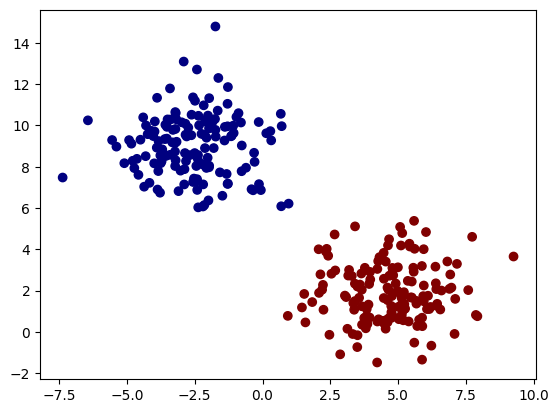

In [18]:
X, y = make_blobs(n_samples=300, centers=2, cluster_std=1.5, random_state=42)
plt.scatter(X[:,0],X[:,1], c=y, cmap='jet')

Now, look at the picture above. We need a separating hyperplane given by a pair $(w,b)$ where $w\in\mathbb{R}^n$ and $b\in \mathbb{R}$ such that

$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $ for every $i=1,\ldots,N$

If this condition is satisfied then the gap between the separating hyperplanes becomes $\frac{2}{\|w\|}$. Thus maximizing the gap becomes equivalent to finding a suitable vector $w$ with the smallest norm.

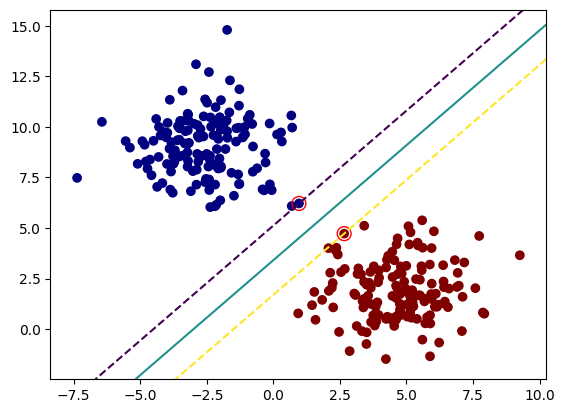

In [19]:
model = SVC(kernel="linear",C=1.05)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y,cmap='jet')
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red"
)

## Hard Margin vs Soft Margin

The standard SVM model operates on the assumption that the data is separable. This situation is described by having a **hard margin**.

In cases where the data is not completely separable, we might allow some mixing within the margin. In these cases, we use a **soft margin** and we would like to allow some points being inside the margin. We call this situation as SVM classifier with *a soft margin*.  In mathematical terms, we do not strictly insist on the condition

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1 $$

and allow points transgress the boundary with some error

$$ y^{(i)}(\mathbf{w}\cdot\mathbf{x}^{(i)}+b) \geq 1-\xi_i $$

But this time we optimize

$$ \|\mathbf{w}\| + C \sum_{i=1}^N \xi_i^2 $$

where $C$ is a hyper-parameter we tune for the application at hand.

Please read [these lecture notes](http://fourier.eng.hmc.edu/e161/lectures/svm/node5.html) and [sklearn SVM with soft margins](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html) from the [sklearn documentation](https://scikit-learn.org/stable/user_guide.html).

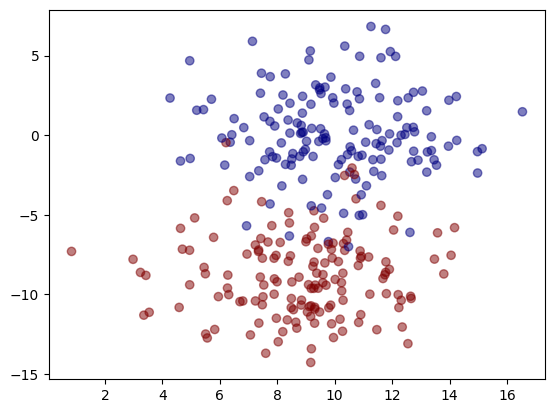

In [56]:
X,y = make_blobs(n_samples=300, centers=2, cluster_std=2.5)
plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',alpha=0.5)

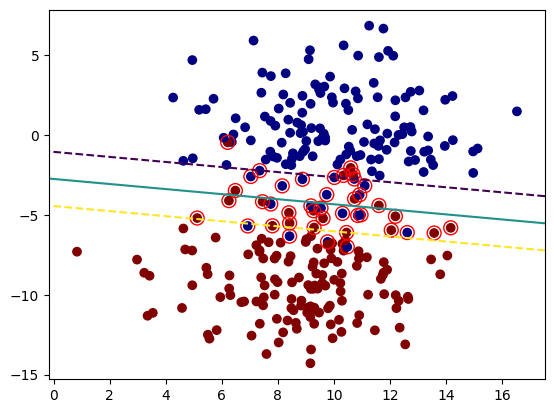

In [57]:
model = SVC(kernel="linear",C=1.0)
model.fit(X,y)

plt.scatter(X[:,0],X[:,1],c=y, cmap='jet')
ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
    model,
    X,
    plot_method="contour",
    levels=[-1, 0, 1],
    linestyles=["--", "-", "--"],
    ax=ax,
)
# plot support vectors
ax.scatter(
    model.support_vectors_[:, 0],
    model.support_vectors_[:, 1],
    s=100,
    linewidth=1,
    facecolors="none",
    edgecolors="red",
)

## The Kernel Trick

There is another parameter that we can play with. That is the inner product we work with. 

Recall that our method heavily relies on the inner product since we either minimize $\|w\|$ subject to 

$y^{(i)}(x^{(i)}\cdot w - b) \geq 0 $

or minimizing the total hinge loss function

$\lambda \|w\| + \sum_i \max(0,1-y^{(i)}(x^{(i)}\cdot w - b))$

We can also use different inner products other than the ordinary Euclidean one:

$x\cdot y = \sum_i x_i y_i$

This method is equivalent to embedding $\mathbb{R}^n$ into another larger $\mathbb{R}^m$ via a (non)linear embedding and then using the ambient Euclidean product in $\mathbb{R}^m$.  This is useful when the original dataset is not linearly separable.

There are three main classes of kernels you can use

* linear
* polynomial
* radial basis function (RBF)

You can read the documentation [here](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html).

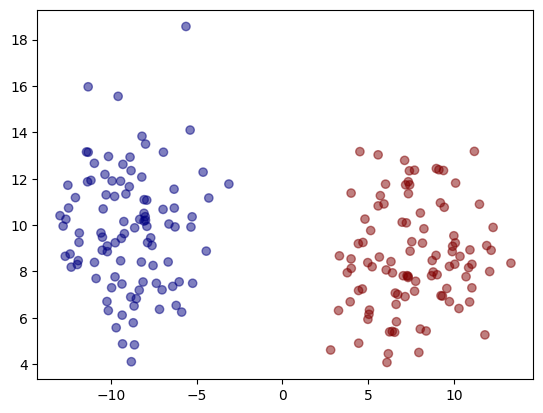

In [22]:
X,y = make_blobs(n_features=2, n_samples=200, centers=2, cluster_std=2.25)
plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',alpha=0.5)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="poly",C=1.0,degree=2)
model.fit(X_train,y_train)
model.score(X_test,y_test)

1.0

## Multiclass SVM

Above we worked with SVM with binary classification. However, SVM is versatile enough to work with multiclass classification problems.

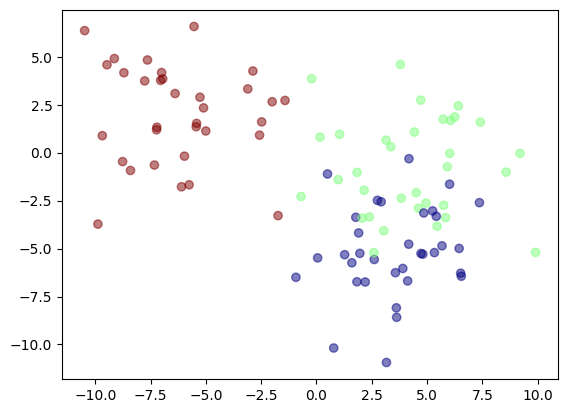

In [24]:
X,y = make_blobs(centers=3, cluster_std=2.5, n_features=200)
plt.scatter(X[:,0],X[:,1],c=y,cmap='jet',alpha=0.5)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.66)

model = SVC(kernel="linear")
model.fit(X_train,y_train)
model.score(X_test,y_test)

1.0